# **This section to read the dataset images and preprocess it**

In [1]:
import glob
import cv2
import keras
from keras.layers.core import Layer
import keras.backend as K
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten
import cv2  
from keras import backend as K 
from keras.utils import np_utils
import math 
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

In [2]:
#classes we need to classify data to it
classes = ['Basketball','Football','Rowing','Swimming','Tennis','Yoga']

#images read from test
dir_name = "/kaggle/input/nn23-sports-image-classification"

# Read jpg images from train data

In [3]:
images_jpg = glob.glob(dir_name + r"/Train/*.jpg")

# Read png images from train data

In [4]:
images_png = glob.glob(dir_name + r"/Train/*.png")

# All images read

In [5]:
allImages= glob.glob(dir_name + r"/Train/*")
print(len(allImages))

1681


# Percentage of (png , jpg , ohterformat)

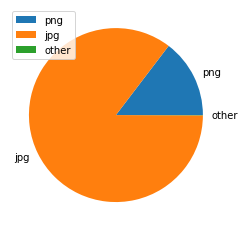

In [6]:
mylabels = ["png" , "jpg" , "other"]
otherLen = len(allImages) - ((len(images_png) + len(images_jpg)))
y = np.array([len(images_png) , len(images_jpg) , otherLen])
plt.pie(y, labels = mylabels)
plt.legend()
plt.show() 

# Since most of images are of type jpg then we are going to reformat all images to be jpg format

In [7]:
for i in range(len(allImages)):
    name_of_sport = allImages[i].split('/')[5].split('_')[0]
    number_image = allImages[i].split('/')[5].split('_')[-1].split('.')[0].lower()
    index=classes.index(name_of_sport)
    name_image = f'/kaggle/working/{index}_{number_image}.jpg'
    image = cv2.imread(allImages[i])
    image = cv2.resize(image,(224,224))
    cv2.imwrite(name_image,image)

In [8]:
images_jpg = glob.glob(r"/kaggle/working/*.jpg")
print(len(images_jpg))

1681


# Preprocessing X and Y before join the model

In [9]:
preprocessed_train = images_jpg
x_train = []
y_train = []

In [10]:
for image in preprocessed_train:
    index = image.split("_")[0].split("/")[-1]
    c = [0,0,0,0,0,0]
    c[int(index)] = 1
    y_train.append(c)
    x_train.append(np.asarray(cv2.imread(image)))

In [11]:
y_train = np.array(y_train)
y_train.reshape(1681 , 1 , 6)

array([[[0, 0, 0, 0, 1, 0]],

       [[0, 1, 0, 0, 0, 0]],

       [[0, 0, 1, 0, 0, 0]],

       ...,

       [[0, 0, 0, 1, 0, 0]],

       [[0, 0, 0, 0, 0, 1]],

       [[0, 1, 0, 0, 0, 0]]])

In [12]:
x_train = np.array(x_train)
x_train.reshape(1681,224,224,3)

array([[[[ 28,   6,   0],
         [ 30,   8,   2],
         [ 33,  11,   5],
         ...,
         [ 30,  11,   4],
         [ 27,   7,   2],
         [ 24,   4,   0]],

        [[ 31,   9,   3],
         [ 33,  11,   5],
         [ 36,  14,   8],
         ...,
         [ 33,  14,   7],
         [ 30,  10,   5],
         [ 28,   8,   3]],

        [[ 33,  11,   5],
         [ 35,  13,   7],
         [ 38,  17,   9],
         ...,
         [ 36,  17,  10],
         [ 33,  13,   8],
         [ 31,  11,   6]],

        ...,

        [[ 25,  10,   8],
         [ 26,  11,   9],
         [ 26,  13,  11],
         ...,
         [ 21,   1,  14],
         [ 23,   1,  13],
         [ 23,   2,  11]],

        [[ 22,   7,   5],
         [ 25,  10,   8],
         [ 26,  11,   9],
         ...,
         [ 23,   3,  15],
         [ 23,   1,  13],
         [ 20,   0,  10]],

        [[ 20,   5,   3],
         [ 24,   9,   7],
         [ 25,  10,   8],
         ...,
         [ 21,   1,  13],
        

In [13]:
print(x_train.shape)

(1681, 224, 224, 3)


In [14]:
print(y_train.shape)

(1681, 6)


# Inception Model

In [15]:
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)
    
    return output

# Initial Bias

In [16]:
kernel_init = keras.initializers.glorot_uniform()
bias_init = keras.initializers.Constant(value=0.1)

# Building Architcture 

In [17]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), padding='same', strides=(2, 2), activation='relu', name='conv_1_7x7/2', kernel_initializer=kernel_init, bias_initializer=bias_init)(input_layer)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)
x = Conv2D(64, (1, 1), padding='same', strides=(1, 1), activation='relu', name='conv_2a_3x3/1')(x)
x = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', name='conv_2b_3x3/1')(x)
x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=64,
                     filters_3x3_reduce=96,
                     filters_3x3=128,
                     filters_5x5_reduce=16,
                     filters_5x5=32,
                     filters_pool_proj=32,
                     name='inception_3a')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=192,
                     filters_5x5_reduce=32,
                     filters_5x5=96,
                     filters_pool_proj=64,
                     name='inception_3b')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=192,
                     filters_3x3_reduce=96,
                     filters_3x3=208,
                     filters_5x5_reduce=16,
                     filters_5x5=48,
                     filters_pool_proj=64,
                     name='inception_4a')


x1 = AveragePooling2D((5, 5), strides=3)(x)
x1 = Conv2D(128, (1, 1), padding='same', activation='relu')(x1)
x1 = Flatten()(x1)
x1 = Dense(1024, activation='relu')(x1)
x1 = Dropout(0.7)(x1)
x1 = Dense(6, activation='softmax', name='auxilliary_output_1')(x1)

x = inception_module(x,
                     filters_1x1=160,
                     filters_3x3_reduce=112,
                     filters_3x3=224,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4b')

x = inception_module(x,
                     filters_1x1=128,
                     filters_3x3_reduce=128,
                     filters_3x3=256,
                     filters_5x5_reduce=24,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4c')

x = inception_module(x,
                     filters_1x1=112,
                     filters_3x3_reduce=144,
                     filters_3x3=288,
                     filters_5x5_reduce=32,
                     filters_5x5=64,
                     filters_pool_proj=64,
                     name='inception_4d')


x2 = AveragePooling2D((5, 5), strides=3)(x)
x2 = Conv2D(128, (1, 1), padding='same', activation='relu')(x2)
x2 = Flatten()(x2)
x2 = Dense(1024, activation='relu')(x2)
x2 = Dropout(0.7)(x2)
x2 = Dense(6, activation='softmax', name='auxilliary_output_2')(x2)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_4e')

x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

x = inception_module(x,
                     filters_1x1=256,
                     filters_3x3_reduce=160,
                     filters_3x3=320,
                     filters_5x5_reduce=32,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5a')

x = inception_module(x,
                     filters_1x1=384,
                     filters_3x3_reduce=192,
                     filters_3x3=384,
                     filters_5x5_reduce=48,
                     filters_5x5=128,
                     filters_pool_proj=128,
                     name='inception_5b')

x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

x = Dropout(0.4)(x)

x = Dense(6, activation='softmax', name='output')(x)

2022-12-22 09:01:44.058379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 09:01:44.059372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 09:01:44.060397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 09:01:44.061196: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 09:01:44.061959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
model = Model(input_layer,[ x , x1, x2], name='inception_v1')
#model = Model(input_layer,x, name='inception_v1')

# Model Summary

In [19]:
model.summary()

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
conv_2a_3x3/1 (Conv2D)          (None, 56, 56, 64)   4160        max_pool_1_3x3/2[0][0]           
_______________________________________________________________________________________

# Data Augmentation

In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False, # Don't randomly flip images vertically
) 

In [21]:
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

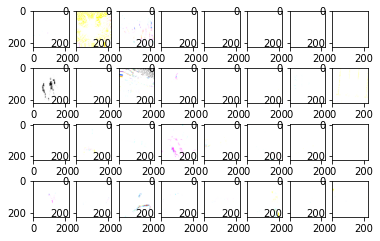

In [22]:
x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [23]:
datagen.fit(x_train)

In [24]:
img_iter

In [25]:
x_train.shape

(1681, 224, 224, 3)

In [26]:
for i in range(0,11):
    x_train = np.concatenate((x_train, img_iter[i][0]))
    y_train = np.concatenate((y_train,img_iter[i][1]))

In [27]:
x_train.shape

(2033, 224, 224, 3)

In [28]:
train_x, x_valid , train_y,y_valid = train_test_split(x_train,y_train,test_size=0.20)

# Training 

In [29]:
epochs = 100
initial_lrate = 0.0001
batch_size = 32
adam = Adam(learning_rate=initial_lrate,)
earlyStopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, mode='max')
############### 3 inputs 
model.compile( loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'], loss_weights=[1,0.3,0.3], optimizer=adam, metrics=['accuracy'])

###### 1 input 
#model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [30]:
# 3 inputs 
#validation_data=(x_valid, [y_valid, y_valid, y_valid]),
history = model.fit(train_x, [train_y, train_y, train_y],validation_data=(x_valid, [y_valid, y_valid, y_valid]), epochs=epochs, callbacks=[earlyStopping])
#history = model.fit(train_x,train_y, validation_data=(x_valid,y_valid), epochs=epochs, batch_size=batch_size, callbacks=[earlyStopping],steps_per_epoch=len(x_train)/batch_size)

2022-12-22 09:02:08.480804: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 979034112 exceeds 10% of free system memory.
2022-12-22 09:02:09.757792: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 979034112 exceeds 10% of free system memory.
2022-12-22 09:02:10.602384: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-12-22 09:02:15.588881: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


51/51 [==============================] - 26s 220ms/step - loss: 0.7578 - output_loss: 0.4303 - auxilliary_output_1_loss: 0.6121 - auxilliary_output_2_loss: 0.4795 - output_accuracy: 0.3690 - auxilliary_output_1_accuracy: 0.3813 - auxilliary_output_2_accuracy: 0.3364 - val_loss: 0.5242 - val_output_loss: 0.3374 - val_auxilliary_output_1_loss: 0.3051 - val_auxilliary_output_2_loss: 0.3177 - val_output_accuracy: 0.5184 - val_auxilliary_output_1_accuracy: 0.5504 - val_auxilliary_output_2_accuracy: 0.5037
Epoch 2/100
51/51 [==============================] - 6s 120ms/step - loss: 0.5024 - output_loss: 0.3129 - auxilliary_output_1_loss: 0.3132 - auxilliary_output_2_loss: 0.3185 - output_accuracy: 0.5652 - auxilliary_output_1_accuracy: 0.5861 - auxilliary_output_2_accuracy: 0.5603 - val_loss: 0.4409 - val_output_loss: 0.2845 - val_auxilliary_output_1_loss: 0.2553 - val_auxilliary_output_2_loss: 0.2659 - val_output_accuracy: 0.6314 - val_auxilliary_output_1_accuracy: 0.6708 - val_auxilliary_out

# Testing Data

In [31]:
import os
names = next(os.walk('/kaggle/input/nn23-sports-image-classification/Test'), (None, None, []))[2]
X_test=[]
img_name=[]
for i in names:
    img=cv2.imread('/kaggle/input/nn23-sports-image-classification/Test/'+i)
    img=cv2.resize(img,(224,224))
    img_name.append(i)
    X_test.append(img)

In [32]:
X_test=np.array(X_test)

In [33]:
results = model.predict(X_test)
results = np.argmax(results,axis = 2)

In [34]:
results=np.array(results)
results

array([[2, 5, 0, ..., 4, 1, 3],
       [2, 5, 0, ..., 4, 1, 3],
       [2, 5, 0, ..., 4, 1, 3]])

In [35]:
results[0]

array([2, 5, 0, 1, 1, 0, 2, 5, 4, 2, 4, 4, 2, 0, 5, 2, 3, 4, 0, 3, 3, 2,
       5, 1, 1, 5, 4, 0, 0, 4, 5, 4, 4, 5, 3, 5, 4, 1, 2, 4, 2, 5, 5, 1,
       0, 4, 4, 3, 0, 5, 2, 0, 5, 1, 0, 1, 0, 3, 5, 1, 0, 0, 4, 4, 2, 1,
       1, 3, 2, 1, 1, 1, 3, 4, 2, 1, 4, 2, 5, 0, 4, 4, 5, 5, 0, 0, 0, 3,
       3, 5, 0, 3, 2, 2, 1, 5, 5, 0, 3, 4, 0, 3, 1, 3, 0, 2, 2, 3, 3, 0,
       5, 3, 0, 3, 1, 5, 1, 0, 5, 4, 2, 2, 1, 1, 2, 2, 1, 5, 3, 0, 0, 1,
       1, 5, 5, 1, 1, 1, 2, 4, 1, 1, 5, 3, 3, 1, 0, 3, 5, 4, 2, 0, 2, 4,
       5, 3, 2, 5, 1, 2, 5, 0, 5, 1, 5, 4, 5, 1, 3, 1, 3, 2, 2, 1, 3, 0,
       5, 2, 3, 2, 4, 3, 1, 5, 5, 0, 1, 0, 4, 2, 2, 3, 5, 1, 0, 5, 1, 4,
       1, 4, 4, 2, 1, 1, 1, 5, 4, 2, 3, 5, 1, 4, 4, 5, 2, 4, 5, 5, 1, 3,
       1, 1, 1, 5, 4, 1, 2, 3, 0, 0, 0, 0, 2, 2, 4, 4, 5, 5, 3, 1, 2, 2,
       0, 1, 5, 4, 5, 3, 5, 3, 1, 3, 4, 1, 4, 4, 0, 3, 1, 3, 3, 5, 1, 1,
       0, 5, 5, 5, 4, 5, 1, 4, 5, 4, 1, 0, 3, 2, 1, 1, 4, 1, 3, 4, 4, 4,
       4, 0, 0, 4, 0, 3, 1, 5, 1, 1, 2, 1, 3, 4, 1,

In [36]:
results[2]

array([2, 5, 0, 1, 1, 0, 1, 5, 4, 2, 4, 4, 2, 0, 5, 2, 3, 4, 4, 2, 3, 2,
       5, 1, 1, 5, 4, 0, 0, 4, 5, 4, 4, 5, 3, 5, 4, 1, 2, 4, 2, 5, 5, 1,
       0, 4, 4, 3, 0, 5, 2, 0, 5, 1, 0, 1, 5, 3, 5, 1, 0, 2, 4, 4, 2, 1,
       1, 3, 2, 1, 1, 1, 3, 4, 2, 1, 4, 2, 5, 4, 4, 4, 5, 5, 0, 0, 0, 3,
       5, 5, 0, 3, 2, 2, 1, 5, 5, 0, 3, 4, 0, 3, 1, 3, 0, 2, 2, 3, 3, 0,
       5, 3, 4, 3, 1, 5, 1, 0, 5, 4, 2, 2, 1, 1, 2, 2, 1, 5, 3, 0, 0, 1,
       1, 5, 5, 1, 1, 1, 2, 4, 1, 1, 5, 2, 5, 4, 0, 3, 5, 4, 2, 0, 2, 4,
       5, 3, 2, 5, 1, 2, 5, 0, 5, 1, 5, 4, 5, 1, 3, 1, 3, 2, 2, 1, 3, 2,
       5, 2, 3, 2, 4, 3, 1, 5, 5, 0, 1, 0, 4, 2, 2, 3, 5, 1, 0, 5, 1, 4,
       1, 4, 4, 2, 1, 1, 1, 5, 4, 2, 3, 5, 1, 4, 4, 4, 2, 4, 5, 5, 1, 3,
       1, 1, 1, 5, 4, 1, 2, 3, 0, 0, 0, 0, 2, 2, 4, 4, 5, 5, 3, 1, 3, 2,
       1, 1, 5, 4, 5, 3, 5, 2, 1, 3, 4, 1, 4, 4, 0, 5, 1, 3, 5, 5, 1, 1,
       0, 5, 5, 5, 4, 5, 1, 4, 5, 4, 1, 5, 3, 2, 1, 1, 4, 1, 3, 4, 4, 4,
       4, 0, 0, 4, 0, 3, 1, 1, 1, 1, 2, 1, 3, 4, 1,

In [37]:
results[1]

array([2, 5, 0, 1, 1, 0, 0, 5, 4, 2, 4, 4, 2, 0, 5, 2, 3, 4, 4, 1, 3, 2,
       5, 1, 1, 5, 4, 0, 0, 4, 5, 4, 4, 5, 3, 5, 4, 1, 2, 4, 2, 5, 5, 1,
       0, 4, 4, 3, 0, 5, 2, 0, 5, 0, 0, 4, 5, 3, 5, 1, 0, 2, 4, 4, 2, 1,
       1, 3, 2, 1, 1, 1, 3, 4, 2, 1, 4, 2, 5, 0, 4, 4, 5, 5, 0, 0, 0, 4,
       5, 5, 0, 3, 2, 3, 1, 5, 5, 0, 3, 4, 0, 3, 1, 3, 0, 2, 2, 3, 3, 0,
       5, 3, 2, 3, 1, 5, 1, 0, 5, 4, 2, 2, 1, 1, 2, 2, 1, 5, 3, 0, 0, 1,
       1, 5, 5, 5, 1, 1, 2, 4, 1, 1, 5, 3, 4, 4, 0, 3, 5, 4, 2, 0, 2, 4,
       5, 3, 2, 5, 1, 2, 5, 0, 5, 5, 5, 4, 5, 1, 3, 1, 3, 2, 2, 1, 3, 2,
       5, 2, 3, 2, 4, 3, 1, 5, 5, 0, 1, 0, 4, 2, 4, 3, 5, 1, 0, 5, 1, 4,
       0, 4, 5, 2, 1, 1, 1, 5, 4, 2, 3, 5, 1, 4, 4, 5, 3, 1, 5, 5, 1, 3,
       1, 1, 1, 5, 4, 0, 2, 3, 0, 0, 0, 0, 2, 2, 4, 4, 5, 5, 2, 1, 2, 2,
       1, 1, 5, 4, 5, 3, 5, 2, 1, 3, 4, 1, 4, 4, 0, 5, 1, 3, 5, 5, 1, 1,
       0, 5, 5, 5, 4, 5, 1, 5, 5, 4, 1, 5, 3, 5, 1, 5, 4, 1, 3, 4, 4, 4,
       4, 0, 0, 4, 0, 3, 1, 1, 1, 1, 2, 1, 3, 4, 1,

In [38]:
submission=pd.DataFrame()
submission['image_name']=img_name
submission['label']=results[1]

# Final Output

In [39]:
submission

,image_name,label
0,623.jpg,2
1,208.jpg,5
2,473.jpg,0
3,333.jpg,1
4,537.jpg,1
...,...,...
683,364.jpg,3
684,90.jpg,3
685,599.jpg,4
686,25.jpg,1


In [40]:
# for checking 
classes = ['Basketball','Football','Rowing','Swimming','Tennis','Yoga']

In [41]:
submission.to_csv(r'/kaggle/working/inceptionv1.csv', index=False)

In [42]:
#history.save('asl_model')